In [18]:
#Your data
#experimental data broken down by clusters

exper = np.array([
    [0.7,0.8,0.6,0.5,1], #1st claster
    [1.1,0.9,0.8,0.8,0.9], #2nd claster
    [0.7,0.6,0.8,0.9,0.7] #3rd claster
])

In [19]:
#control or comparing data broken down by clusters

control = np.array([
    [1,1,1.5,0.5,1], #1st claster
    [1.1,1.2,0.8,1.3,1.0], #2nd claster
    [0.8,0.9,1,0.7,0.8] #3rd claster
])

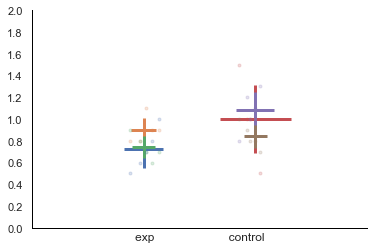

In [20]:
display_data(exper, control)

In [21]:
inter, intra = SD(exper, control)
print('Mean experimetal', exper.mean())
print('Mean control', control.mean())
print('inter cluster SD =', inter)
print('intra cluster SD =', intra)

Mean experimetal 0.7866666666666666
Mean control 0.9733333333333334
inter cluster SD = 0.098657657246325
intra cluster SD = 0.14719601443879746


In [22]:
print('p value adjusted = ', p_value(exper, control))

p value adjusted =  0.16871896490464922


In [23]:
pb_err = what_probability_false_negative(exper, control)
print('Probability of false negative error if your mean and SD are true is', pb_err)

k = 1
while pb_err > 0.2:
    pb_err = what_probability_false_negative(exper, control, plus_number_claster=k)
    print('If there are ', k + len(exper), ' clusters, the false negative error will be' , pb_err)
    k += 1

Probability of false negative error if your mean and SD are true is 0.403
If there are  4  clusters, the false negative error will be 0.377
If there are  5  clusters, the false negative error will be 0.296
If there are  6  clusters, the false negative error will be 0.187


In [24]:
print('exper mean =', exper.mean() )
print('control mean =', control.mean() )
print('What if exper mean = control mean = ', (exper.mean()+control.mean())/2)

print('Then probability of false positive error is ', what_probability_false_positive(exper, control))

exper mean = 0.7866666666666666
control mean = 0.9733333333333334
What if exper mean = control mean =  0.88
Then probability of false positive error is  0.027


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set_theme()
from scipy import stats
from random import randint
from scipy.stats import t as tpdf
import matplotlib.ticker as ticker

In [2]:
def SD(exper, control):
    
    #print('inter_claster_SD: exper and control')
    #print(exper.mean(axis=1).std(ddof=1), control.mean(axis=1).std(ddof=1))
    inter_claster_SD = exper.mean(axis=1).std(ddof=1)
    
    #print('intra_claster_SD: exper and control')
    #print(np.sqrt((exper.std(axis=1, ddof=1)**2).sum()/(len(exper))), np.sqrt((control.std(axis=1, ddof=1)**2).sum()/(len(control))))
    intra_claster_SD = np.sqrt((exper.std(axis=1, ddof=1)**2).sum()/(len(exper)))
    
    return inter_claster_SD, intra_claster_SD
    
    

In [3]:
def p_value(exper, control):
    
    inter_claster_SD, intra_claster_SD = SD(exper, control)
    
    N_claster = len(control)
    N_intra_claster = len(control[0])
    
    ICC = inter_claster_SD**2/(inter_claster_SD**2+intra_claster_SD**2)
    
    N = N_claster * N_intra_claster
    
    # correction factor for t-distribution
    c = np.sqrt(((N-2)-2*(N_intra_claster-1)*ICC)/((N-2)*(1+(N_intra_claster-1)*ICC)))
    
    # corrected degrees of freedom
    df = ((N-2)-2*(N_intra_claster-1)*ICC)**2/((N-2)*(1-ICC)**2 + N_intra_claster*(N-2*N_intra_claster)*(ICC**2)+2*(N-2*N_intra_claster)*ICC*(1-ICC))
    
    # standard deviation of two datasets
    s = np.sqrt((N*exper.std()**2+N*control.std()**2)/(2*N-2))
    
    # t-test
    t1=abs(exper.mean()-control.mean())/(s*np.sqrt(1/N+1/N))
    
    # corrected t-test
    ta=c*t1
    
    p_value_correct = 2*(1-tpdf.cdf(ta, df))
    
    return p_value_correct

In [4]:
def what_probability_false_negative(exper, control, N=1000, plus_number_claster=1):
    
    inter_claster_SD, intra_claster_SD = SD(exper, control)
    return probability_false_negative(N=1000, N_per_day = len(exper[0]), N_days = (plus_number_claster + len(exper)), true_exp_mean = exper.mean(), true_control_mean = control.mean(), inter_day_SD = inter_claster_SD, sigma = intra_claster_SD)[2]


In [5]:
def what_probability_false_positive(exper, control, N=1000):
    
    inter_claster_SD, intra_claster_SD = SD(exper, control)
    mean = (exper.mean() + control.mean()) / 2
    #print(mean, exper.mean(),  control.mean())
    return probability_false_positive(
        N=1000, N_per_day = len(exper[0]),
        N_days = len(exper), true_exp_mean = mean,
        true_control_mean = mean, inter_day_SD = inter_claster_SD,
        sigma = intra_claster_SD
    )[2]

In [6]:
def p_values(N_per_day = 10, N_days = 5, true_exp_mean = 1, true_control_mean = 1, inter_day_SD = 0.1, sigma = 0.3, graph=False):
    
    mean_exp = true_exp_mean*(1 + inter_day_SD*np.random.normal(0, 1, N_days))
    mean_control = true_control_mean*(1 + inter_day_SD*np.random.normal(0, 1, N_days))
    day_exp = []
    mean_days_exp = []
    
    day_control = []
    mean_days_control = []
    
    for i in range(N_days):
        tmp = mean_exp[i]*(1 + sigma*np.random.normal(0, 1, N_per_day))
        mean_days_exp.append(tmp.mean())
        day_exp.append(tmp)

        tmp1 = mean_control[i]*(1 + sigma*np.random.normal(0, 1, N_per_day))
        mean_days_control.append(tmp1.mean())
        day_control.append(mean_control[i] + sigma*np.random.normal(0, 1, N_per_day))

    day_exp = np.array(day_exp)
    mean_days_exp = np.array(mean_days_exp)

    day_control = np.array(day_control)
    mean_days_control = np.array(mean_days_control)
    
    p_value_all = stats.ttest_ind(day_exp.reshape((N_days*N_per_day)), day_control.reshape((N_days*N_per_day)))[1]
    p_value_mean = stats.ttest_ind(mean_days_exp,  mean_days_control)[1]
    #print(stats.ttest_ind(day_exp.reshape((N_days*N_per_day)), day_control.reshape((N_days*N_per_day))))
    
    ICC = inter_day_SD**2/(inter_day_SD**2+sigma**2)
    
    N=N_per_day*N_days;
    # correction factor for t-distribution
    c=np.sqrt(((N-2)-2*(N_per_day-1)*ICC)/((N-2)*(1+(N_per_day-1)*ICC)))
    # corrected degrees of freedom
    df=((N-2)-2*(N_per_day-1)*ICC)**2/((N-2)*(1-ICC)**2 + N_per_day*(N-2*N_per_day)*(ICC**2)+2*(N-2*N_per_day)*ICC*(1-ICC))
    # standard deviation of two datasets
    #s=np.sqrt(((N-1)*day_exp.std()**2+(N-1)*day_control.std()**2)/(2*N-2))
    s=np.sqrt((N*day_exp.std()**2+N*day_control.std()**2)/(2*N-2))
    #print(day_exp.std())
    # t-test
    t1=abs(day_exp.mean()-day_control.mean())/(s*np.sqrt(1/N+1/N))
    
    # corrected t-test
    ta=c*t1
    p_value_correct = 2*(1-tpdf.cdf(ta, df))
    
    
    '''
    p_value_all_self_calculate = 2*(1-tpdf.cdf(t1, 2*N-2))
    
    
    s2 = np.sqrt(((N_days)*mean_days_exp.std()**2+(N_days)*mean_days_control.std()**2)/(2*N_days-2))
    t2=abs(mean_days_exp.mean()-mean_days_control.mean())/(s2*np.sqrt(1/N_days+1/N_days))
    p_value_mean_self_calculate = 2*(1-tpdf.cdf(t2, 2*N_days-2))
    '''
    if graph:
        colors = []

        for i in range(N_days):
            colors.append('#%06X' % randint(0, 0xFFFFFF))
        for i in range(N_days):
            plt.scatter(np.random.uniform(0.9,1.1,N_per_day), day_exp[i], color=colors[i])
            plt.scatter(np.random.uniform(1.9,2.1,N_per_day), day_control[i], color=colors[i])
            plt.axis([0,3,-1,2])
            plt.plot([0.8,1.2], [mean_days_exp[i],mean_days_exp[i]], color=colors[i])
            plt.plot([1.8,2.2], [mean_days_control[i],mean_days_control[i]], color=colors[i])
            plt.xlabel('exp                          control') 
    
    return np.array([p_value_all, p_value_mean, p_value_correct])

In [7]:
def probability_false_negative(N=1000, N_per_day = 10, N_days = 5, true_exp_mean = 0.8, true_control_mean = 1, inter_day_SD = 0.1, sigma = 0.3):
    if true_exp_mean == true_control_mean:
        print('ERROR: true_exp_mean = true_control_mean')
    false_all = 0
    false_mean = 0
    false_modified = 0
    for i in range(N):
        p = p_values(N_per_day = N_per_day, N_days = N_days, true_exp_mean = true_exp_mean, true_control_mean = true_control_mean, inter_day_SD = inter_day_SD, sigma = sigma)
        if p[0] > 0.05 :
            false_all += 1
        if p[1] > 0.05:
            false_mean +=1
        if p[2] > 0.05:
            false_modified +=1
            
    return [false_all/N, false_mean/N, false_modified/N ]

In [8]:
def probability_false_positive(N=1000, N_per_day = 10, N_days = 5, true_exp_mean = 1, true_control_mean = 1, inter_day_SD = 0.1, sigma = 0.3):
    if true_exp_mean != true_control_mean:
        print('ERROR: true_exp_mean != true_control_mean')
    false_all = 0
    false_mean = 0
    false_modified = 0
    for i in range(N):
        p = p_values(N_per_day = N_per_day, N_days = N_days, true_exp_mean = true_exp_mean, true_control_mean = true_control_mean, inter_day_SD = inter_day_SD, sigma = sigma)
        if p[0] < 0.05 :
            false_all += 1
        if p[1] < 0.05:
            false_mean +=1
        if p[2] < 0.05:
            false_modified +=1
    return [false_all/N, false_mean/N, false_modified/N]


In [17]:
def display_data(data_exp, data_control):
    """ display data (all experiments and means per clusters)
    INPUT: experimental data (matrix) & control data (matrix)
    OUTPUT: None """
    
    #Определяем размерность входных данных
    N_clusters_exp = len(data_exp)
    N_clusters_control = len(data_control)
    N_per_cluster_exp = len(data_exp[0])
    N_per_cluster_control = len(data_control[0])
    

    #Считаем средние величины по кластерам
    data_exp_mean = data_exp.mean(axis=1)
    data_control_mean = data_control.mean(axis=1)
    
    #Устанавливаем параметры будущего графика
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    fig, ax = plt.subplots()
    
    #Определяем цвета точек разных кластеров
    color_exp = ['C{k}'.format(k=i) for i in range(N_clusters_exp)]
    color_control = ['C{k}'.format(k=i + N_clusters_exp) for i in range(N_clusters_control)]


    #Устанавливаем небольшое смещение точек по оси абцисс для наглядности для exp
    arr_exp= np.ones((1,N_per_cluster_exp))+0.15/np.sqrt(N_clusters_exp)*np.random.randn(1,N_per_cluster_exp)
    
    #Строим эти точки соответсвующих цветов для exp
    for i in range(N_clusters_exp): 
            plt.plot(arr_exp[0], data_exp[i],'.',markersize=6,color=color_exp[i], alpha=0.2)
    #Строим кресты для средних значений
    #plt.scatter(np.ones(N_clusters_exp), data_exp_mean, 1000, color_exp,'+',lineWidths=3)
    plt.errorbar(np.ones(N_clusters_exp), data_exp_mean, xerr= data_exp.std(axis=1),yerr= data_exp.std(axis=1) ,ecolor=color_exp, elinewidth=3 , fmt='None')
    
    
    #Аналогично все тоже самое для контроля
    arr_control=2*np.ones((1,N_per_cluster_control))+0.15/np.sqrt(N_clusters_control)*np.random.randn(1,N_per_cluster_control)
    for i in range(N_clusters_control):
            plt.plot(arr_control[0], data_control[i],'.',markersize=6,color=color_control[i], alpha=0.2)
    #plt.scatter(2*np.ones(N_clusters_control), data_control_mean, 200, color_control,'o',lineWidths=3)
    plt.errorbar(2*np.ones(N_clusters_control), data_control_mean, xerr= data_control.std(axis=1),yerr= data_control.std(axis=1) , ecolor=color_control, elinewidth=3, fmt='None' )

    
    #Устанавливаем параметры графика
    ax.set_xlim(0,3) #Границы по оси абцисс
    ax.set_ylim(0,2) #Границы по оси ординат
    ax.patch.set_visible(False)
    plt.xticks([]) #Убираем деления по оси икс
    plt.xlabel('exp                      control') #подпись к графику

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))#  Устанавливаем интервал больших вспомогательных делений:
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))#  Устанавливаем интервал маленьких вспомогательных делений:
    ax.patch.set_visible(False) #Невидимый задний фон
    ax.spines['right'].set_visible(False) #Невидимая верхняя линия бокса рисунка
    ax.spines['top'].set_visible(False)#Невидимая правая линия бокса рисунка

    plt.show()